<a href="https://colab.research.google.com/github/ygeszvain/projects/blob/master/Time_Series_Analysis_GOLD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit: https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
df=pd.read_csv('data_m3.csv', delimiter=',')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (7190, 4)


,DATE,GOLD,SLVR,PLAT
0,04/02/1990,368.4000,4.9375,471.0000
1,04/03/1990,375.0000,5.0010,475.8000
2,04/04/1990,374.2500,5.0100,475.7000
3,04/05/1990,378.4000,5.1475,481.7500
4,04/06/1990,377.7000,5.1790,481.0000


In [44]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['GOLD'] = pd.to_numeric(df['GOLD'], errors='coerce')
df = df.dropna(subset=['GOLD'])
df['year'] = df['DATE'].apply(lambda x: x.year)
df['quarter'] = df['DATE'].apply(lambda x: x.quarter)
df['month'] = df['DATE'].apply(lambda x: x.month)
df['day'] = df['DATE'].apply(lambda x: x.day)
df=df.loc[:,['DATE','GOLD', 'year','quarter','month','day']]
df.sort_values('DATE', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["DATE"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.DATE.min())
print('The time series ends on: ', df.DATE.max())

Number of rows and columns after removing missing values: (7137, 7)
The time series starts from:  1990-04-02 00:00:00
The time series ends on:  2018-09-21 00:00:00


In [45]:
stat, p = stats.normaltest(df.GOLD)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=1956.163, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -0.9784131913911653
Skewness of normal distribution: 0.7243630559308317


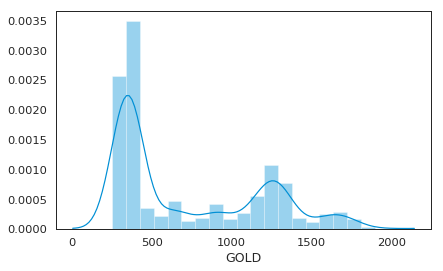

In [46]:
sns.distplot(df.GOLD);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.GOLD)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.GOLD)))

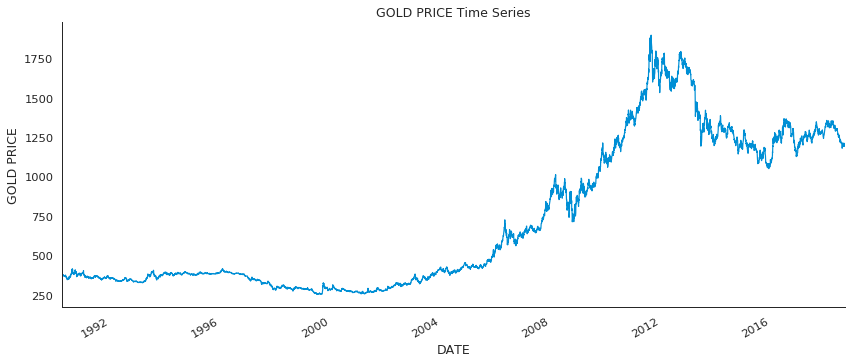

In [47]:
df1=df.loc[:,['DATE','GOLD']]
df1.set_index('DATE',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('GOLD PRICE')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('GOLD PRICE Time Series')
sns.despine(top=True)
plt.show();

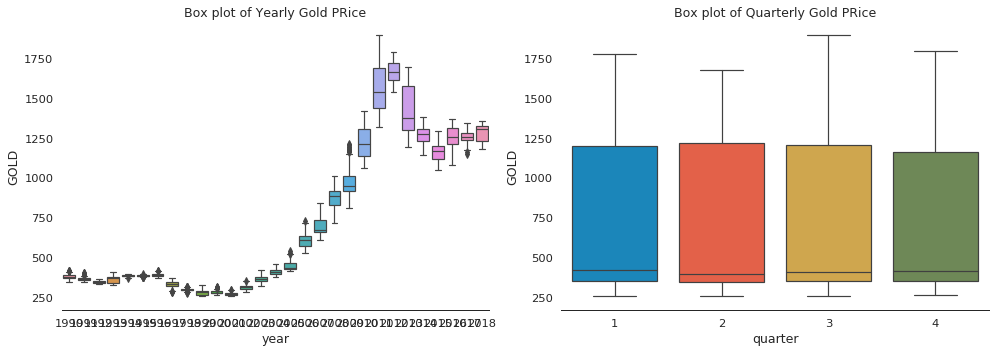

In [48]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="GOLD", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Gold PRice')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="GOLD", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Gold PRice')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
GOLD,7137.0000,714.9155,461.0748,252.8000,348.4500,407.9000,1197.0000,1895.0000


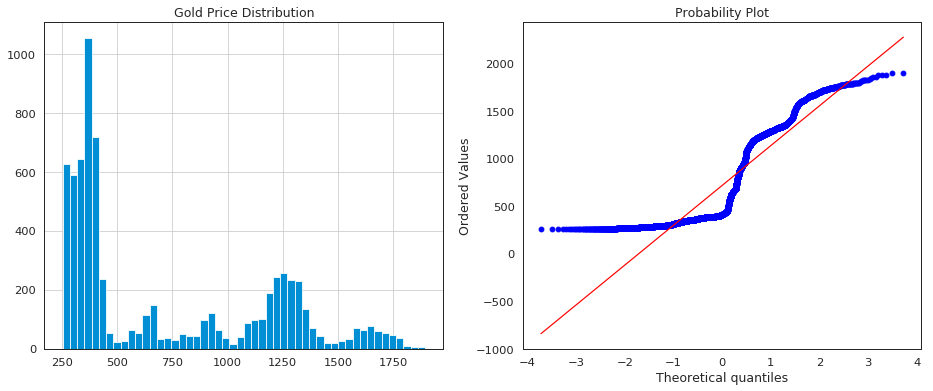

In [49]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['GOLD'].hist(bins=50)
plt.title('Gold Price Distribution')
plt.subplot(1,2,2)
stats.probplot(df['GOLD'], plot=plt);
df1.describe().T

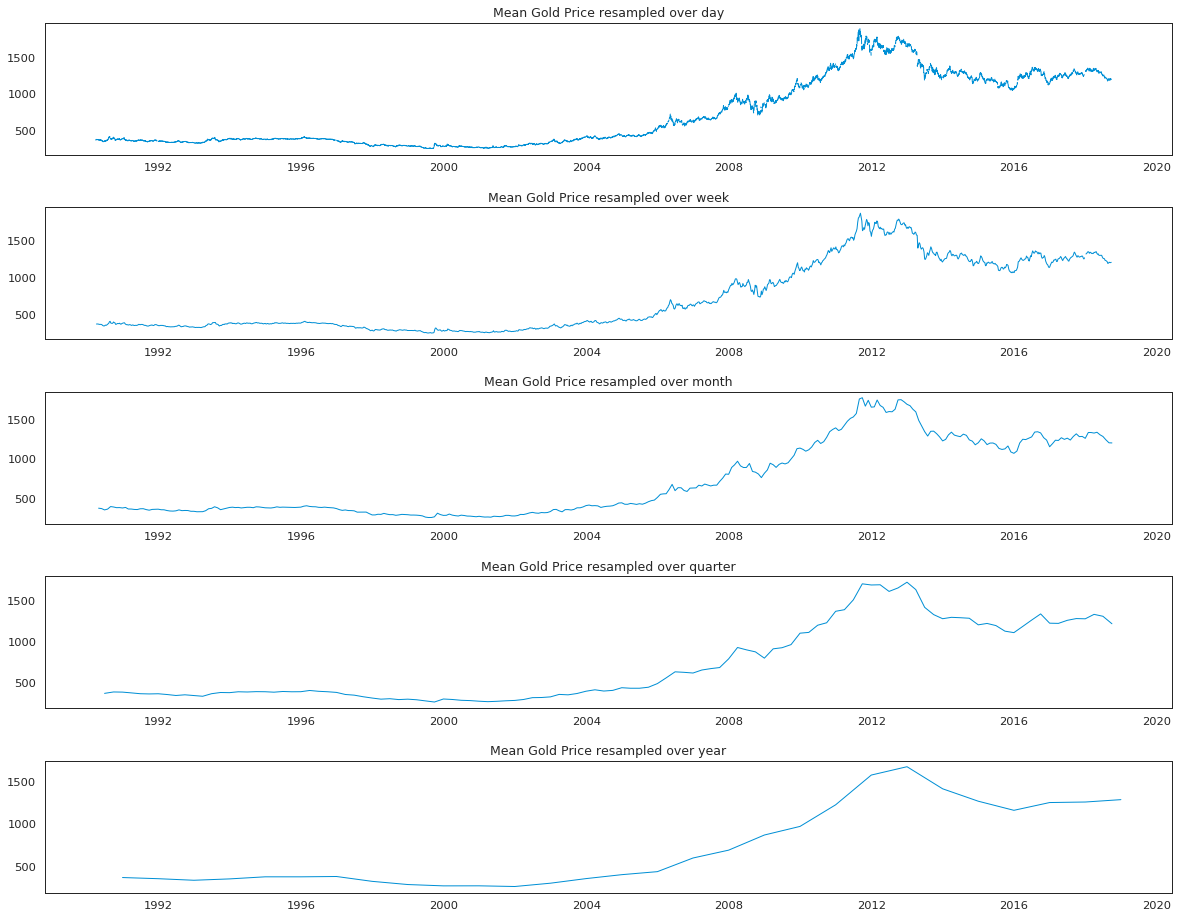

In [50]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['GOLD'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Gold Price resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['GOLD'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Gold Price resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['GOLD'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Gold Price resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['GOLD'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Gold Price resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['GOLD'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Gold Price resampled over year')
ax5.tick_params(axis='both', which='major');

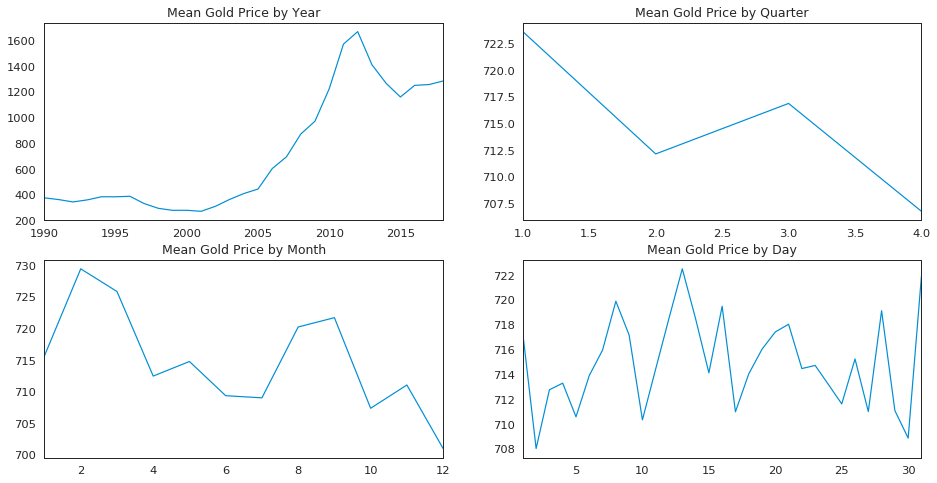

In [51]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').GOLD.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Gold Price by Year')

plt.subplot(2,2,2)
df.groupby('quarter').GOLD.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Gold Price by Quarter')

plt.subplot(2,2,3)
df.groupby('month').GOLD.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Gold Price by Month')

plt.subplot(2,2,4)
df.groupby('day').GOLD.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Gold Price by Day');

**Dickey-Fuller test**

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

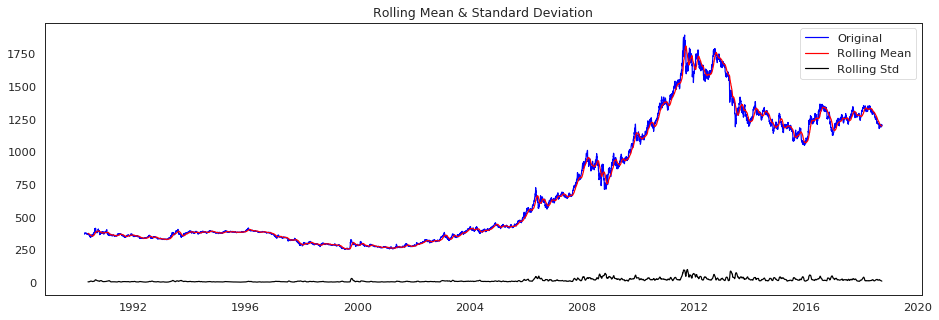

<Results of Dickey-Fuller Test>
Test Statistic                  -0.4966
p-value                          0.8927
#Lags Used                      35.0000
Number of Observations Used   7101.0000
Critical Value (1%)             -3.4313
Critical Value (5%)             -2.8619
Critical Value (10%)            -2.5670
dtype: float64


In [52]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.GOLD.dropna())

**we will not reject the null hypothesis H0, the data does have a unit root and is not stationary.**

In [0]:
dataset = df.GOLD.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [54]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 5678 samples, validate on 1397 samples
Epoch 1/20
5678/5678 [==============================] - 2s 291us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 2/20
5678/5678 [==============================] - 0s 86us/step - loss: 8.4553e-04 - val_loss: 9.1652e-04
Epoch 3/20
5678/5678 [==============================] - 0s 88us/step - loss: 6.0666e-04 - val_loss: 0.0015
Epoch 4/20
5678/5678 [==============================] - 0s 87us/step - loss: 5.9909e-04 - val_loss: 5.0459e-04
Epoch 5/20
5678/5678 [==============================] - 0s 84us/step - loss: 6.9951e-04 - val_loss: 3.4910e-04
Epoch 6/20
5678/5678 [==============================] - 0s 83us/step - loss: 6.0116e-04 - val_loss: 3.8509e-04
Epoch 7/20
5678/5678 [==============================] - 0s 86us/step - loss: 4.8059e-04 - val_loss: 6.6721e-04
Epoch 8/20
5678/5678 [==============================] - 1s 89us/step - loss: 5.1343e-04 - val_loss: 3.0240e-04
Epoch 9/20
5678/5678 [==============================] - 0s 85us/step - loss

In [55]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 52.503370179431826
Train Root Mean Squared Error: 54.522147545411734
Test Mean Absolute Error: 34.64241867231011
Test Root Mean Squared Error: 39.768950831390505


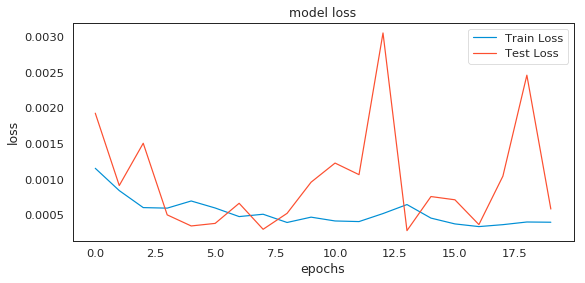

In [56]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

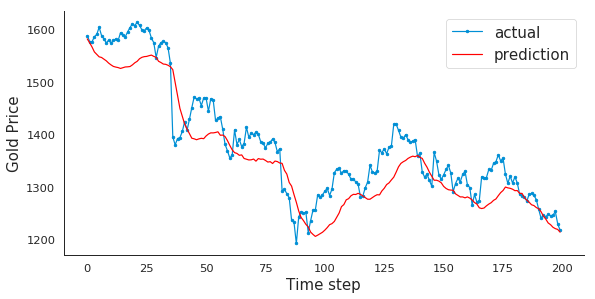

In [57]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Gold Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [58]:
!pip install fbprophet

In [0]:
import timeit
%matplotlib inline
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [60]:
df = df[['DATE','GOLD']]
df = df.rename(index=str, columns={"GOLD": "y", "DATE": "ds"})
df.head()

,ds,y
0,1990-04-02,368.4000
1,1990-04-03,375.0000
2,1990-04-04,374.2500
3,1990-04-05,378.4000
4,1990-04-06,377.7000


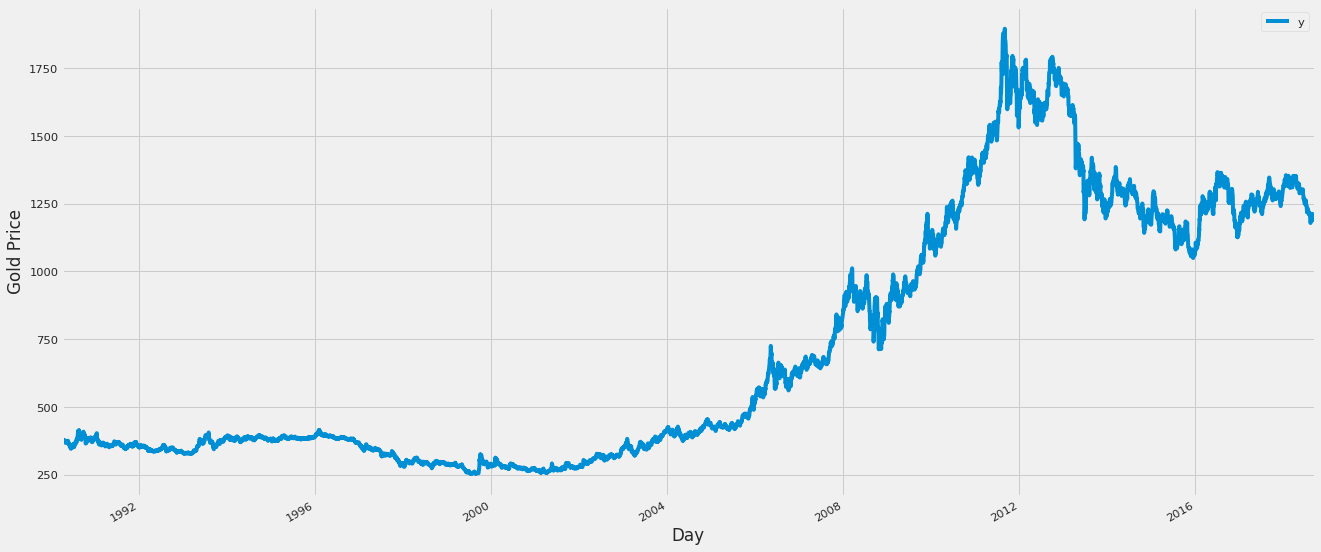

In [61]:
ax = df.set_index('ds').plot(figsize=(20, 10))
ax.set_ylabel('Gold Price')
ax.set_xlabel('Day')

plt.show()

In [63]:
# MODEL
# Set the uncertainty interval to 95% (the Prophet default is 80%)

bev_model = Prophet(interval_width=0.95)
bev_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [65]:
future_dates = bev_model.make_future_dataframe(periods=24, freq='M')
future_dates.tail()

,ds
7156,2020-04-30
7157,2020-05-31
7158,2020-06-30
7159,2020-07-31
7160,2020-08-31


In [66]:
# MODEL

forecast = bev_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7156,2020-04-30,1123.8482,846.4861,1374.1196
7157,2020-05-31,1109.8513,800.2130,1366.4619
7158,2020-06-30,1105.6201,797.8986,1381.6364
7159,2020-07-31,1105.6916,745.1387,1397.4100
7160,2020-08-31,1111.6702,730.9919,1430.7767


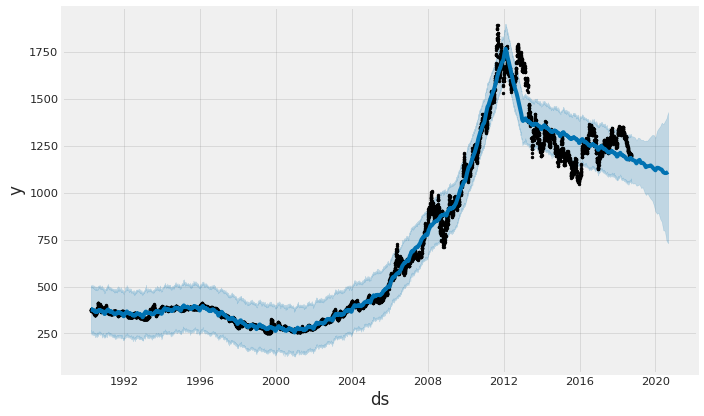

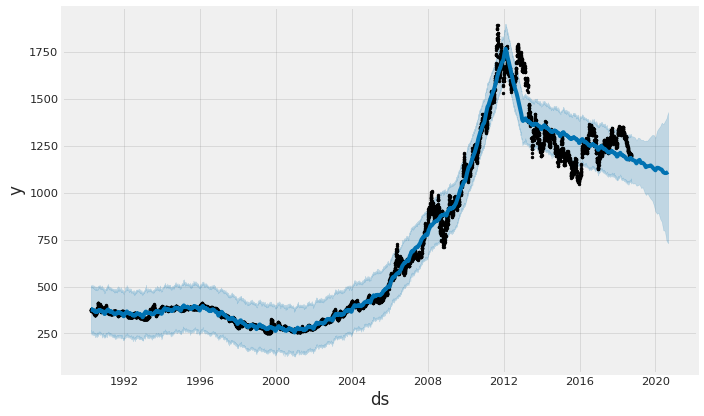

In [67]:
# MODEL

bev_model.plot(forecast, uncertainty=True)

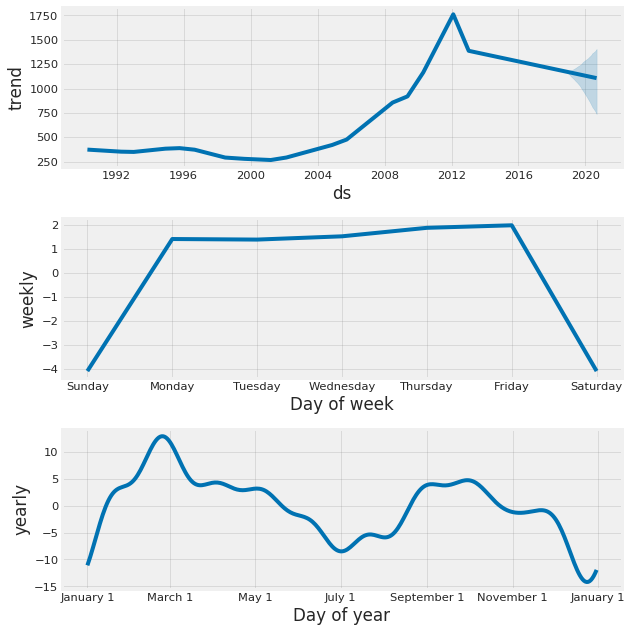

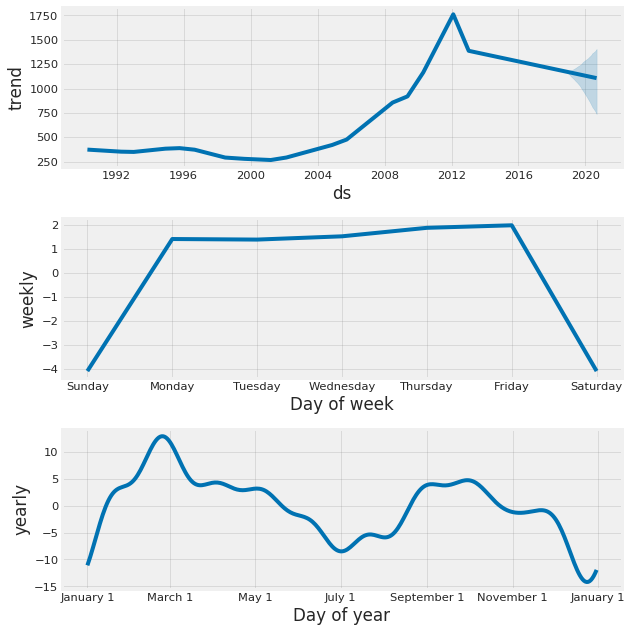

In [68]:
# INTERPRET

bev_model.plot_components(forecast)

